In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from scipy.stats import gamma

import qiskit
from qiskit import QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_aer import AerSimulator
from qiskit_ibm_provider import IBMProvider
import qiskit_ibm_runtime

import time
import os

In [2]:
def get_cond_prob(bit_string_counts):
    # convert count dict to pd frame
    df = pd.DataFrame.from_dict(
        bit_string_counts, orient='index').reset_index()
    df.columns = ['bits', 'counts']

    # split data and ancilla
    df['data_bits'] = df['bits'].str[-2:]
    df['bath_bits'] = df['bits'].str[:-2]
    df = df.drop('bits', axis=1)

    # find result with 00 data bit
    A0_bits = df[df['data_bits'] == '00']
    A0_bits = A0_bits.rename(
        columns={'counts': 'cond_counts'}).drop('data_bits', axis=1)

    # compute cond prob using left merge
    ZB_df = df.groupby('bath_bits').sum(numeric_only=True).reset_index()
    ZB_df = ZB_df.merge(A0_bits, on='bath_bits', how='left').fillna(0)
    ZB_df['cond_prob'] = ZB_df['cond_counts'] / ZB_df['counts']
    ZB_df = ZB_df.drop(['cond_counts', 'bath_bits'], axis=1)

    # expand into long format
    #ZB_df = ZB_df.reindex(ZB_df.index.repeat(ZB_df['counts']))
    
    return ZB_df['cond_prob'].to_numpy()

In [3]:
def create_circuit(n_step, n_depth, n_bath):
    n_wires = 2 + n_bath
    n_param = 2 * n_depth * n_step
    n_register = 2 + n_bath * n_step

    # circuit parameter storages
    param_data0 = ParameterVector('data_0', length=n_param)
    param_data1 = ParameterVector('data_1', length=n_param)
    param_bath = [ParameterVector(
        'bath_' + str(b), length=n_param) for b in range(n_bath)]

    q = QuantumRegister(n_wires, 'q')
    c = ClassicalRegister(n_register, 'c')
    circuit = QuantumCircuit(q, c)

    for t in range(n_step):
        for d in range(n_depth):
            param_id = 2 * d + 2 * n_depth * t
            circuit.ry(param_data0[param_id], 0)
            circuit.rz(param_data0[param_id + 1], 0)
            circuit.ry(param_data1[param_id], 1)
            circuit.rz(param_data1[param_id + 1], 1)

            for b in range(n_bath):
                circuit.ry(param_bath[b][param_id], 2 + b)
                circuit.rz(param_bath[b][param_id + 1], 2 + b)

            circuit.cx(0, 1)

            for b in range(n_bath - 1):
                circuit.cx(2 + b, 2 + b + 1)

            circuit.cx(1, 2)

        register_id = 2 + t * n_bath
        circuit.measure(range(2, n_wires), range(
            register_id, register_id + n_bath))

        if t < n_step - 1:
            for b in range(n_bath):
                circuit.reset(2 + b)

    circuit.measure((0, 1), (0, 1))

    return circuit

## 2 Qubits, HEA circuit

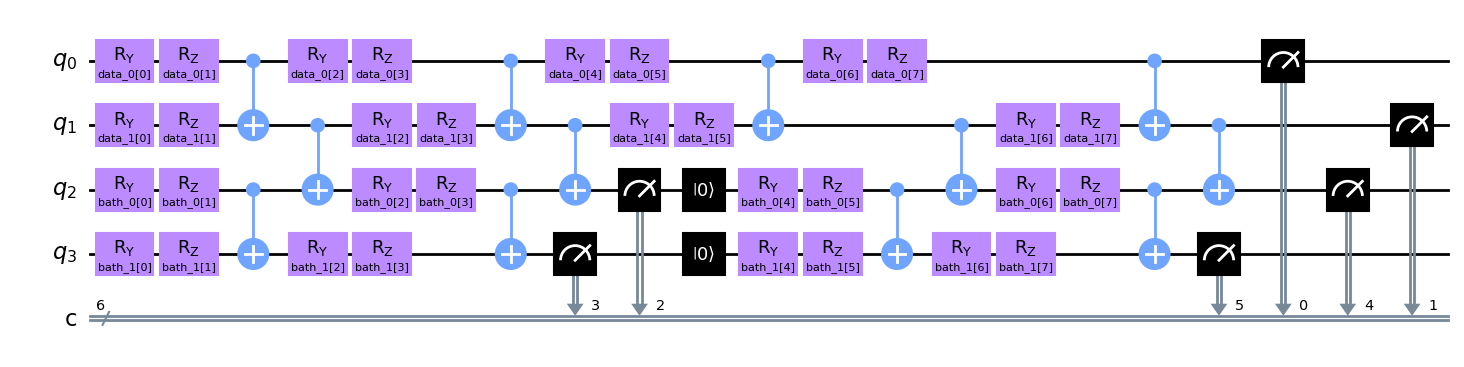

In [4]:
# plot a simple circuit
circuit = create_circuit(2, 2, 2)
circuit.draw('mpl')

# PoP dynamics (ideal device)

In [11]:
n_step = 1
n_depth = 5
n_bath = 2
n_shot, shot_name = 1e5, '1e5'

circuit = create_circuit(n_step, n_depth, n_bath)

# generate random params
np.random.seed(1)
n_total_param = (2 + n_bath) * (2 * n_depth * n_step)
param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
bound_circuit = circuit.assign_parameters(param_random)

# simulate
job = AerSimulator().run(bound_circuit, shots=n_shot)
res = job.result().get_counts(bound_circuit)
phat = get_cond_prob(res)

with open(f"data/experiment/PoP/ideal/count_Nb{n_bath}L{n_depth}T{n_step}_s{shot_name}.pkl", "wb") as file:
    pickle.dump(res, file)
    
np.save(f'data/experiment/PoP/ideal/condP_Nb{n_bath}L{n_depth}T{n_step}_s{shot_name}.npy', phat)
print(f'step={n_step}')

step=1


Text(0.5, 0.9, 'Noiseless, shots=1e6')

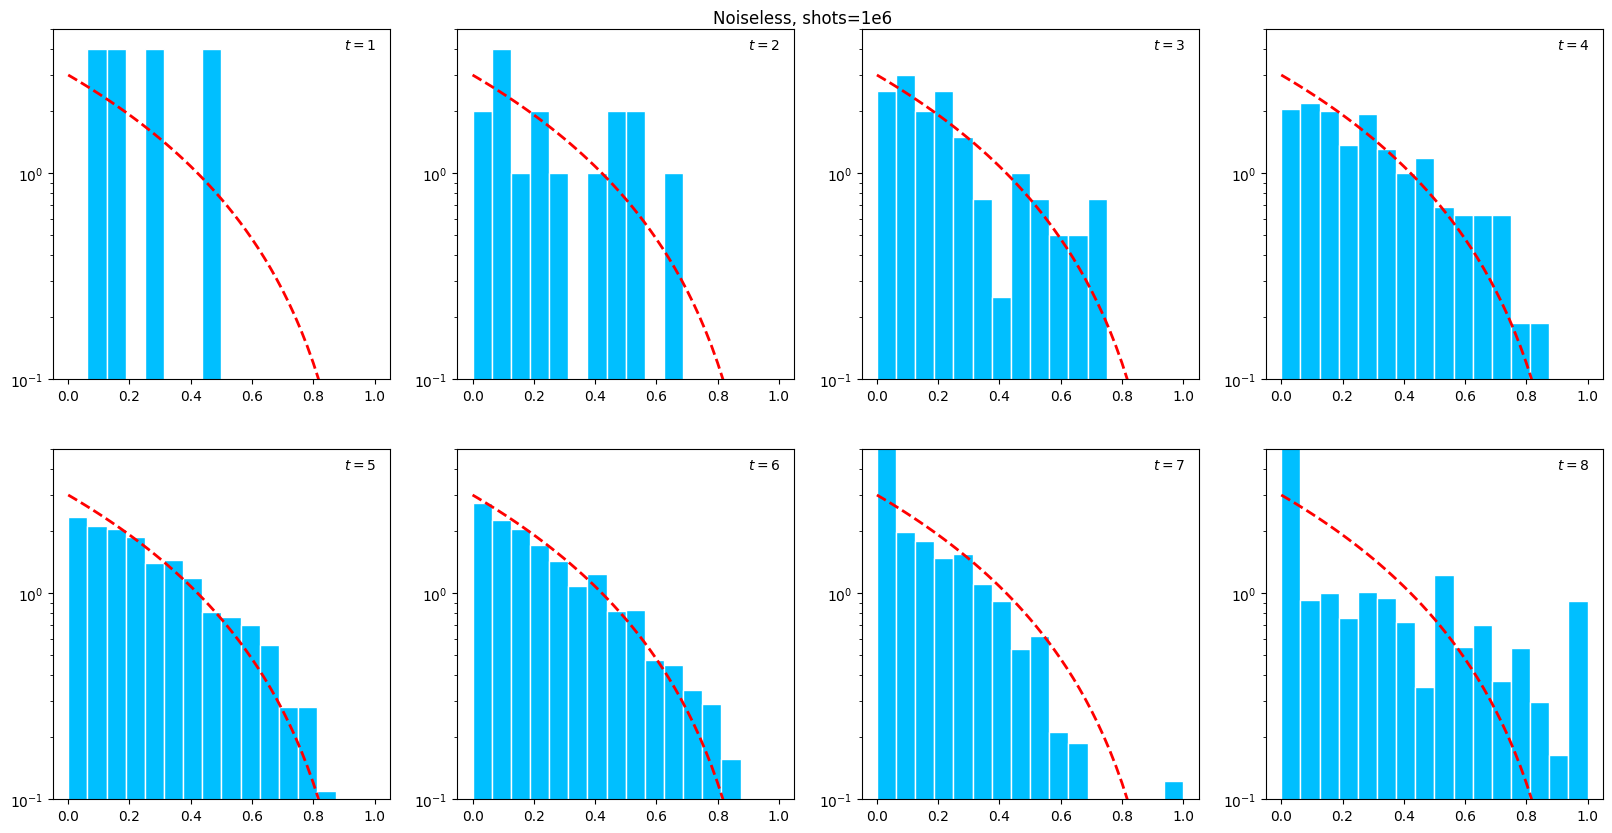

In [115]:
n_depth = 5
n_bath = 2
n_shot = 1e6

condP = []
for t in range(1, 9):
    each = np.load(f'data/experiment/Pop/ideal/condP_Nb{n_bath}L{n_depth}T{t}_s1e6.npy')
    condP.append(each)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
qs = np.linspace(0, 100, 51)/100
for i in range(8):
    axs[i//4, i%4].hist(condP[i], bins=np.linspace(0, 1, 17), density=True, color='deepskyblue', edgecolor='white', 
                label=fr'$t={i+1}$')
    axs[i//4, i%4].plot(qs, (2**2 - 1)*(1-qs)**(2**2-2), '--', lw=2, color='r')
    axs[i//4, i%4].set_yscale('log')
    axs[i//4, i%4].set_ylim(0.1, 5)
    axs[i//4, i%4].text(0.9, 4, fr'$t={i+1}$')
fig.suptitle(f'Noiseless, shots=1e6', y=0.9)

Text(0.5, 0.9, 'Noiseless, shots=1e5')

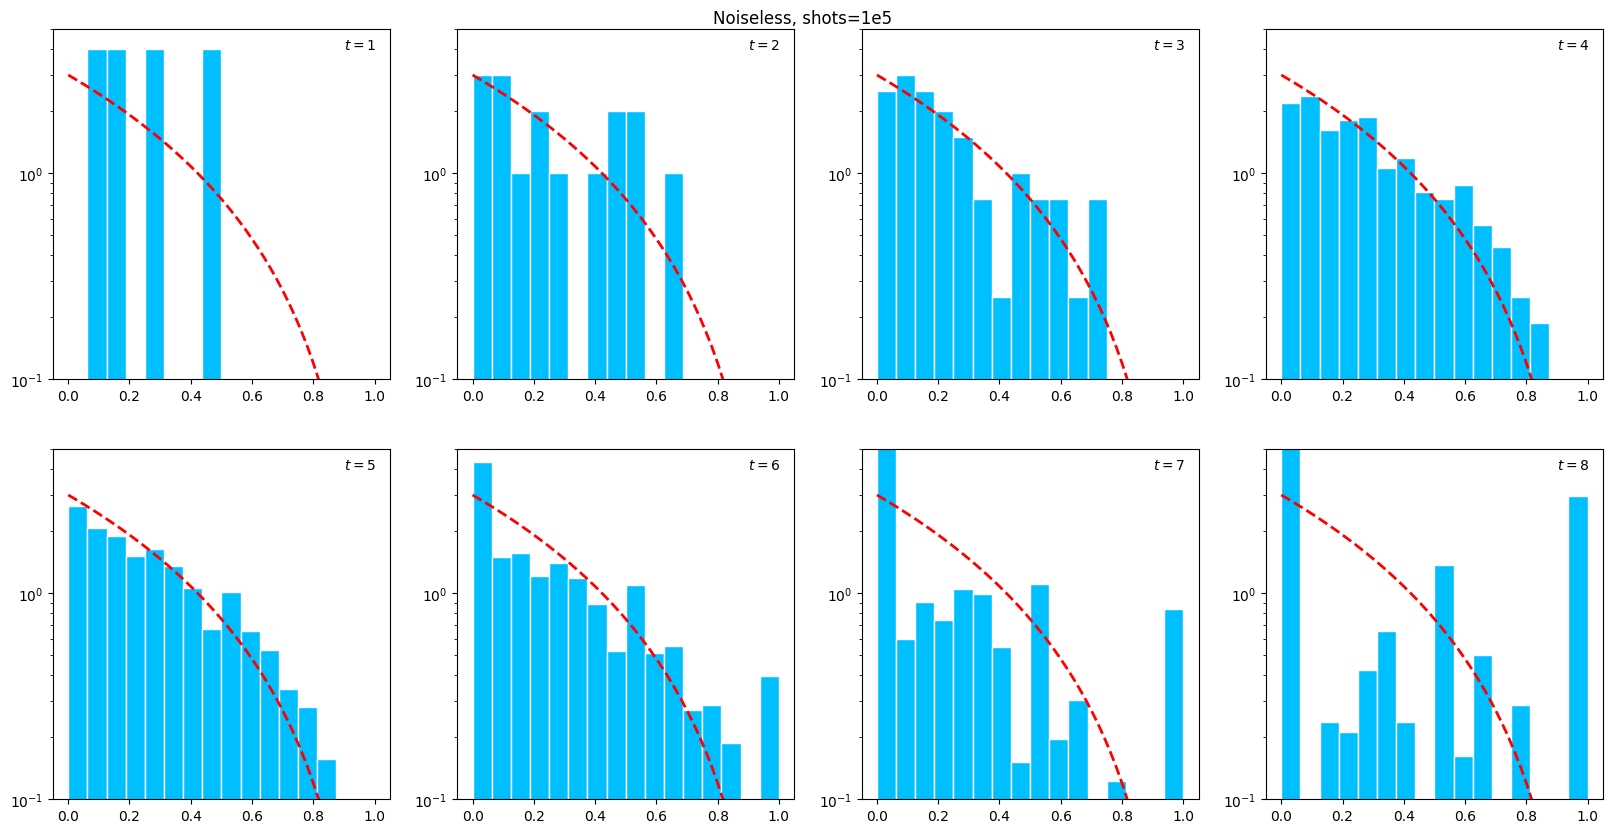

In [116]:
n_depth = 5
n_bath = 2
n_shot = 1e5

condP = []
for t in range(1, 9):
    each = np.load(f'data/experiment/Pop/ideal/condP_Nb{n_bath}L{n_depth}T{t}_s1e5.npy')
    condP.append(each)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
qs = np.linspace(0, 100, 51)/100
for i in range(8):
    axs[i//4, i%4].hist(condP[i], bins=np.linspace(0, 1, 17), density=True, color='deepskyblue', edgecolor='white', 
                label=fr'$t={i+1}$')
    axs[i//4, i%4].plot(qs, (2**2 - 1)*(1-qs)**(2**2-2), '--', lw=2, color='r')
    axs[i//4, i%4].set_yscale('log')
    axs[i//4, i%4].set_ylim(0.1, 5)
    axs[i//4, i%4].text(0.9, 4, fr'$t={i+1}$')
fig.suptitle(f'Noiseless, shots=1e5', y=0.9)

## Noise Simulation

In [72]:
with open('IBMQ_token_usc.txt', 'r') as f:
    TOKEN = f.read().strip()
provider = IBMProvider()

In [57]:
provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')
backend_sim = AerSimulator.from_backend(backend)

In [58]:
# new circuit
backend_name = 'brisbane'

n_step = 1
n_depth = 5
n_bath = 2
n_shot, shot_name = 1e5, '1e5'

circuit = create_circuit(n_step, n_depth, n_bath)
transpiled_circuit = transpile(circuit, backend)

np.random.seed(1)
n_total_param = (2 + n_bath) * (2 * n_depth * n_step)
param_random = np.random.uniform(0, 4. * np.pi, n_total_param)
bound_circuit = transpiled_circuit.assign_parameters(param_random)

job = backend_sim.run(bound_circuit, shots=n_shot)
res = job.result().get_counts(bound_circuit)
phat = get_cond_prob(res)

path = f'data/experiment/PoP/{backend_name}Simu'
if not os.path.exists(path):
    os.mkdir(path)

with open(os.path.join(path, f"count_Nb{n_bath}L{n_depth}T{n_step}_s{shot_name}_{backend_name}Simu.pkl"), "wb") as file:
        pickle.dump(res, file)
        
np.save(os.path.join(path, f'condP_Nb{n_bath}L{n_depth}T{n_step}_s{shot_name}_{backend_name}Simu.npy'), phat)

Text(0, 0.5, '$p(z_B z_A)$')

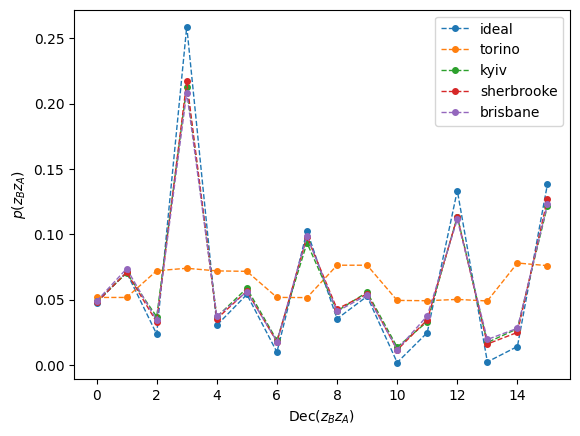

In [86]:
n_step = 1
with open(f'data/experiment/PoP/ideal/count_Nb{n_bath}L{n_depth}T{n_step}_s{shot_name}.pkl', 'rb') as file:
    ct_ideal = pickle.load(file)

backend_list = ['torino', 'kyiv', 'sherbrooke', 'brisbane']
ct_exp = []
for name in backend_list:
    with open(f'data/experiment/PoP/{name}Simu/count_Nb{n_bath}L{n_depth}T{n_step}_s{shot_name}_{name}Simu.pkl', 'rb') as file:
        each = pickle.load(file)
    ct_exp.append(each)

p_id = np.zeros(4*4**n_step)
p_exp = np.zeros((len(backend_list), 4*4**n_step))
for k in range(4*4**n_step):
    s = np.binary_repr(k, width=2+2*n_step)
    p_id[k] = ct_ideal[s]/1e5
    for j in range(len(backend_list)):
        p_exp[j, k] = ct_exp[j][s]/1e5
    
plt.plot(p_id, 'o--',  markersize=4, lw=1, label='ideal')
for i in range(len(backend_list)):
    plt.plot(p_exp[i], 'o--',  markersize=4, lw=1, label=f'{backend_list[i]}')
plt.legend()
plt.xlabel(r'${\rm Dec}(z_B z_A)$')
plt.ylabel(r'$p(z_B z_A)$')

Text(0, 0.5, '$p(z_B 0)$')

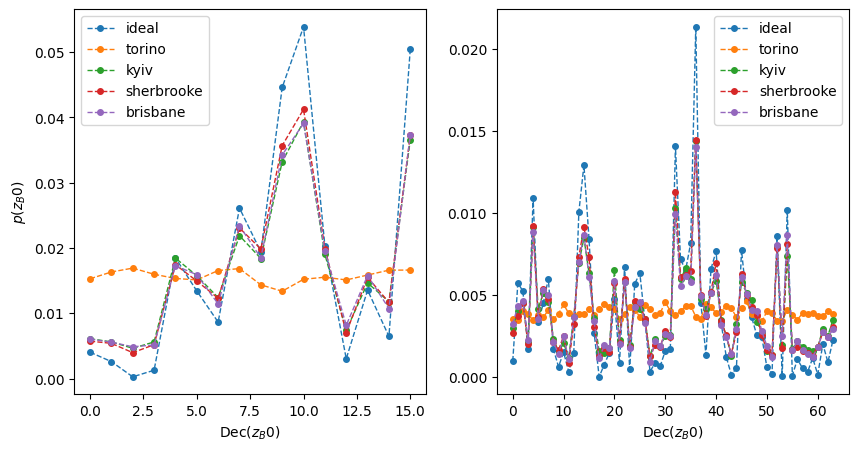

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for n_step in range(2, 4):
    with open(f'data/experiment/PoP/ideal/count_Nb{n_bath}L{n_depth}T{n_step}_s{shot_name}.pkl', 'rb') as file:
        ct_ideal = pickle.load(file)

    backend_list = ['torino', 'kyiv', 'sherbrooke', 'brisbane']
    ct_exp = []
    for name in backend_list:
        with open(f'data/experiment/PoP/{name}Simu/count_Nb{n_bath}L{n_depth}T{n_step}_s{shot_name}_{name}Simu.pkl', 'rb') as file:
            each = pickle.load(file)
        ct_exp.append(each)

    p_id = np.zeros(4*4**n_step)
    p_exp = np.zeros((len(backend_list), 4*4**n_step))
    for k in range(4*4**n_step):
        s = np.binary_repr(k, width=2+2*n_step)
        p_id[k] = ct_ideal[s]/1e5
        for j in range(len(backend_list)):
            p_exp[j, k] = ct_exp[j][s]/1e5
        
    axs[n_step-2].plot(p_id[::4], 'o--', markersize=4, lw=1, label='ideal')
    for i in range(len(backend_list)):
        axs[n_step-2].plot(p_exp[i, ::4], 'o--',  markersize=4, lw=1, label=f'{backend_list[i]}')
    axs[n_step-2].legend()
    axs[n_step-2].set_xlabel(r'${\rm Dec}(z_B 0)$')
axs[0].set_ylabel(r'$p(z_B 0)$')

Text(0.5, 0.9, 'torino Noise Simu')

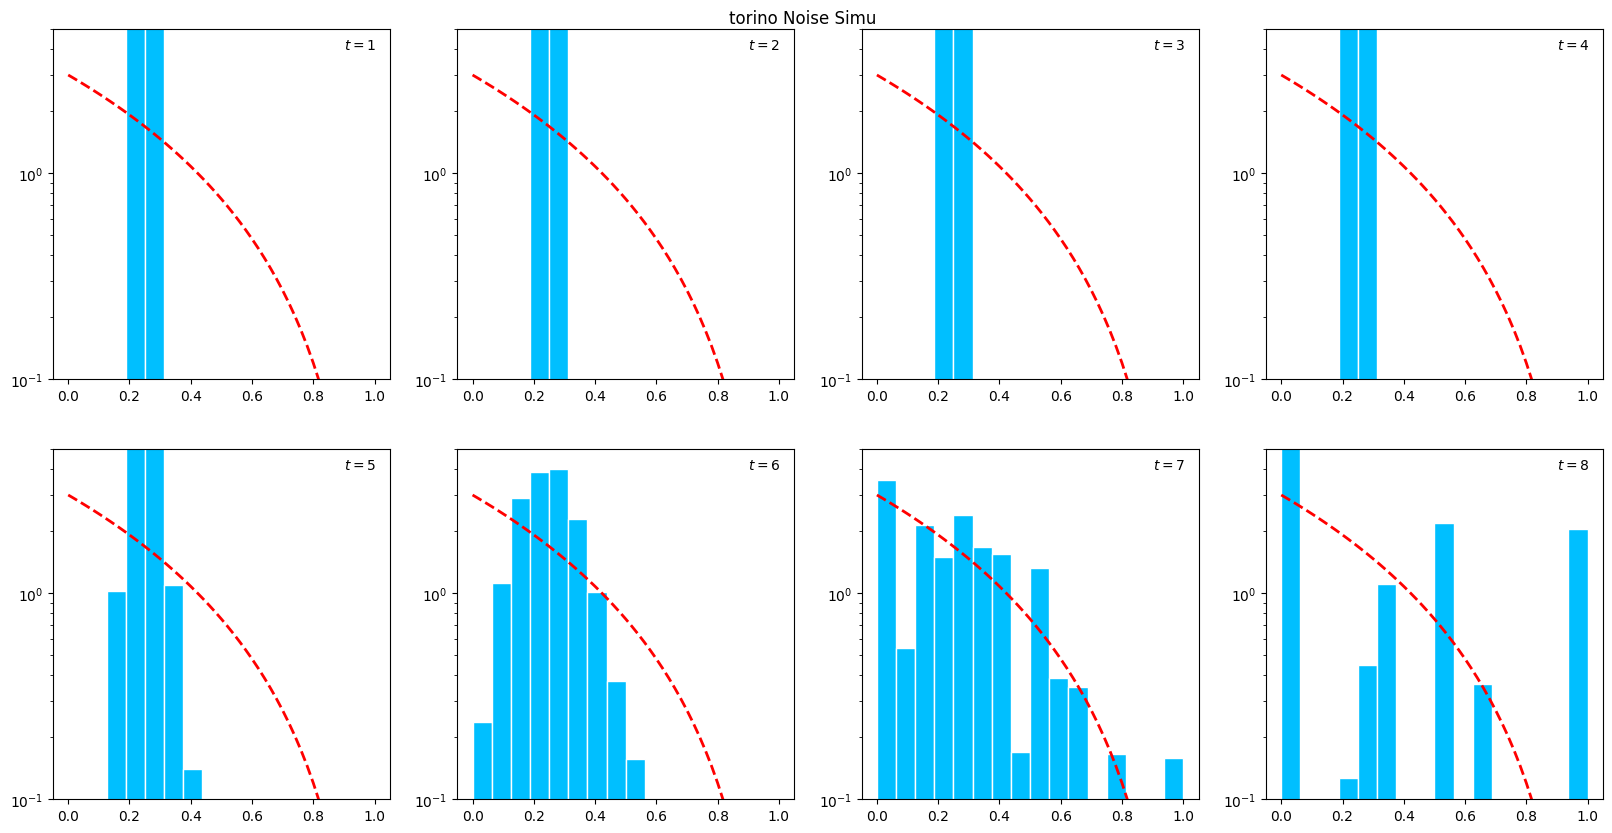

In [113]:
backend_name = 'torino'
n_depth = 5
n_bath = 2
n_shot = 1e5

condP = []
for t in range(1, 9):
    each = np.load(f'data/experiment/PoP/{backend_name}Simu/condP_Nb{n_bath}L{n_depth}T{t}_s1e5_{backend_name}Simu.npy')
    condP.append(each)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
qs = np.linspace(0, 100, 51)/100
for i in range(8):
    axs[i//4, i%4].hist(condP[i], bins=np.linspace(0, 1, 17), density=True, color='deepskyblue', edgecolor='white', 
                label=fr'$t={i+1}$')
    axs[i//4, i%4].plot(qs, (2**2 - 1)*(1-qs)**(2**2-2), '--', lw=2, color='r')
    axs[i//4, i%4].set_yscale('log')
    axs[i//4, i%4].set_ylim(0.1, 5)
    axs[i//4, i%4].text(0.9, 4, fr'$t={i+1}$')
fig.suptitle(f'{backend_name} Noise Simu', y=0.9)

Text(0.5, 0.9, 'kyiv Noise Simu')

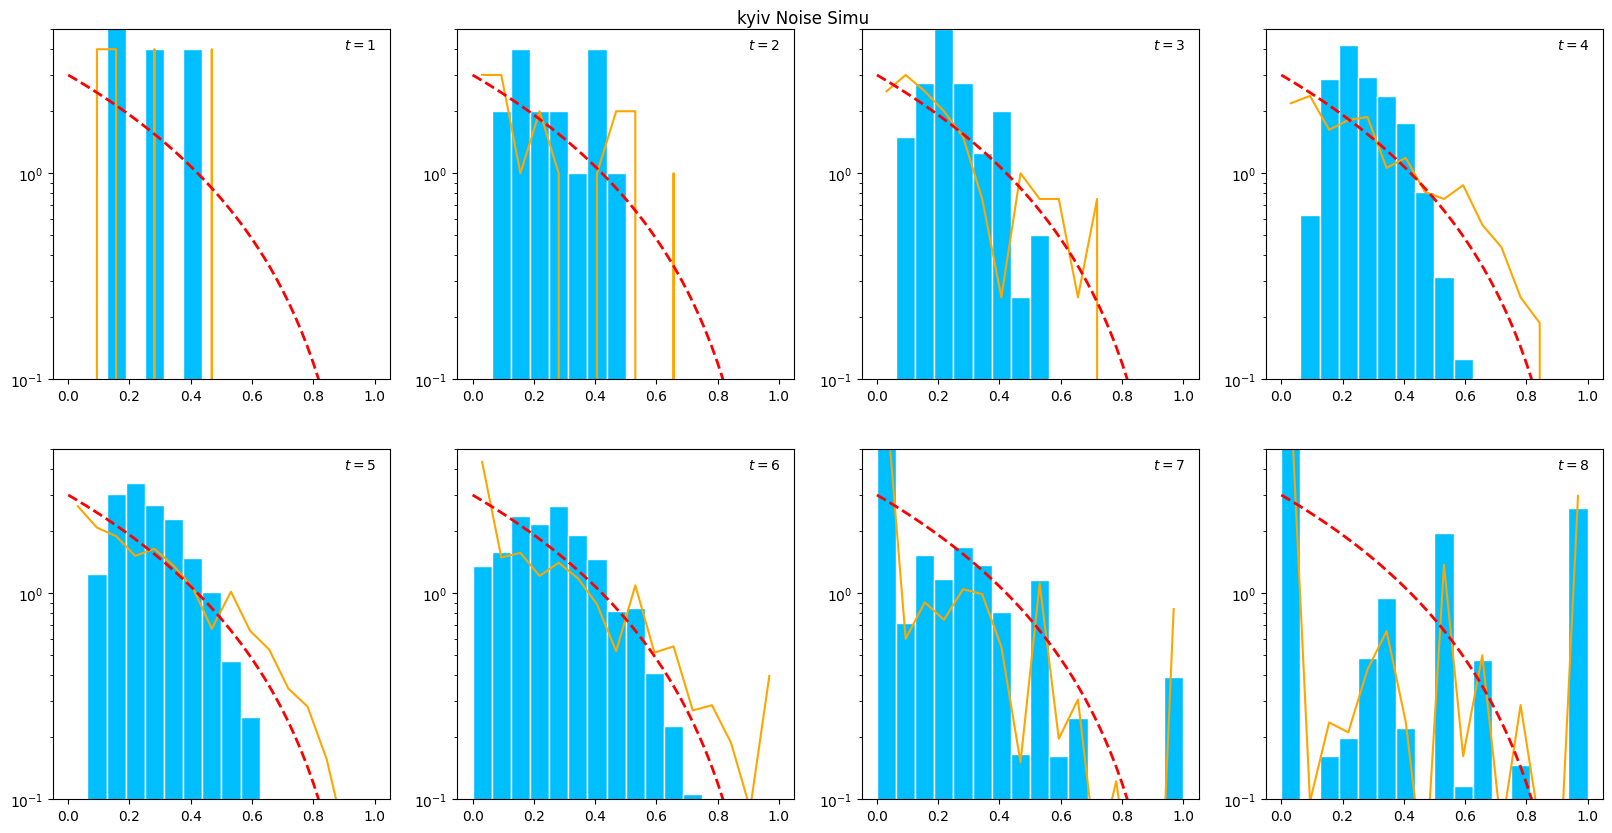

In [114]:
backend_name = 'kyiv'
n_depth = 5
n_bath = 2
n_shot = 1e5

condP = []
for t in range(1, 9):
    each = np.load(f'data/experiment/PoP/{backend_name}Simu/condP_Nb{n_bath}L{n_depth}T{t}_s1e5_{backend_name}Simu.npy')
    condP.append(each)
condP_id = []
for t in range(1, 9):
    each = np.load(f'data/experiment/PoP/ideal/condP_Nb{n_bath}L{n_depth}T{t}_s1e5.npy')
    condP_id.append(each)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
qs = np.linspace(0, 100, 51)/100
for i in range(8):
    axs[i//4, i%4].hist(condP[i], bins=np.linspace(0, 1, 17), density=True, color='deepskyblue', edgecolor='white', 
                label=fr'$t={i+1}$')
    h, b = np.histogram(condP_id[i], bins=np.linspace(0, 1, 17), density=True)
    axs[i//4, i%4].plot((b[1:]+b[:-1])/2, h, c='orange')
    axs[i//4, i%4].plot(qs, (2**2 - 1)*(1-qs)**(2**2-2), '--', lw=2, color='r')
    axs[i//4, i%4].set_yscale('log')
    axs[i//4, i%4].set_ylim(0.1, 5)
    axs[i//4, i%4].text(0.9, 4, fr'$t={i+1}$')
fig.suptitle(f'{backend_name} Noise Simu', y=0.9)

Text(0.5, 0.9, 'sherbrooke Noise Simu')

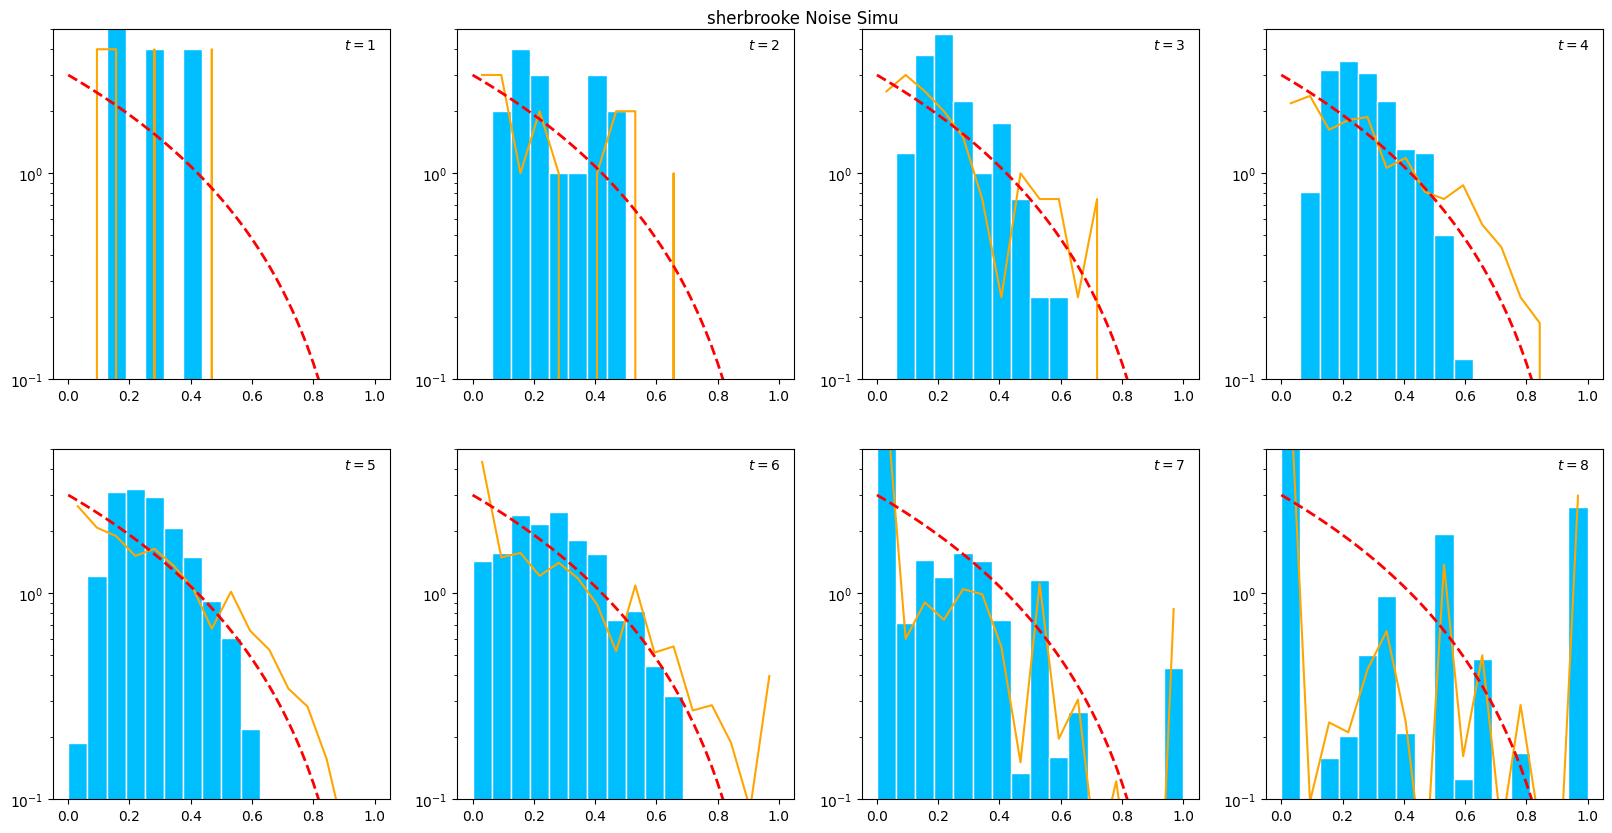

In [117]:
backend_name = 'sherbrooke'
n_depth = 5
n_bath = 2
n_shot = 1e5

condP = []
for t in range(1, 9):
    each = np.load(f'data/experiment/PoP/{backend_name}Simu/condP_Nb{n_bath}L{n_depth}T{t}_s1e5_{backend_name}Simu.npy')
    condP.append(each)
condP_id = []
for t in range(1, 9):
    each = np.load(f'data/experiment/PoP/ideal/condP_Nb{n_bath}L{n_depth}T{t}_s1e5.npy')
    condP_id.append(each)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
qs = np.linspace(0, 100, 51)/100
for i in range(8):
    axs[i//4, i%4].hist(condP[i], bins=np.linspace(0, 1, 17), density=True, color='deepskyblue', edgecolor='white', 
                label=fr'$t={i+1}$')
    h, b = np.histogram(condP_id[i], bins=np.linspace(0, 1, 17), density=True)
    axs[i//4, i%4].plot((b[1:]+b[:-1])/2, h, c='orange')
    axs[i//4, i%4].plot(qs, (2**2 - 1)*(1-qs)**(2**2-2), '--', lw=2, color='r')
    axs[i//4, i%4].set_yscale('log')
    axs[i//4, i%4].set_ylim(0.1, 5)
    axs[i//4, i%4].text(0.9, 4, fr'$t={i+1}$')
fig.suptitle(f'{backend_name} Noise Simu', y=0.9)

Text(0.5, 0.9, 'brisbane Noise Simu')

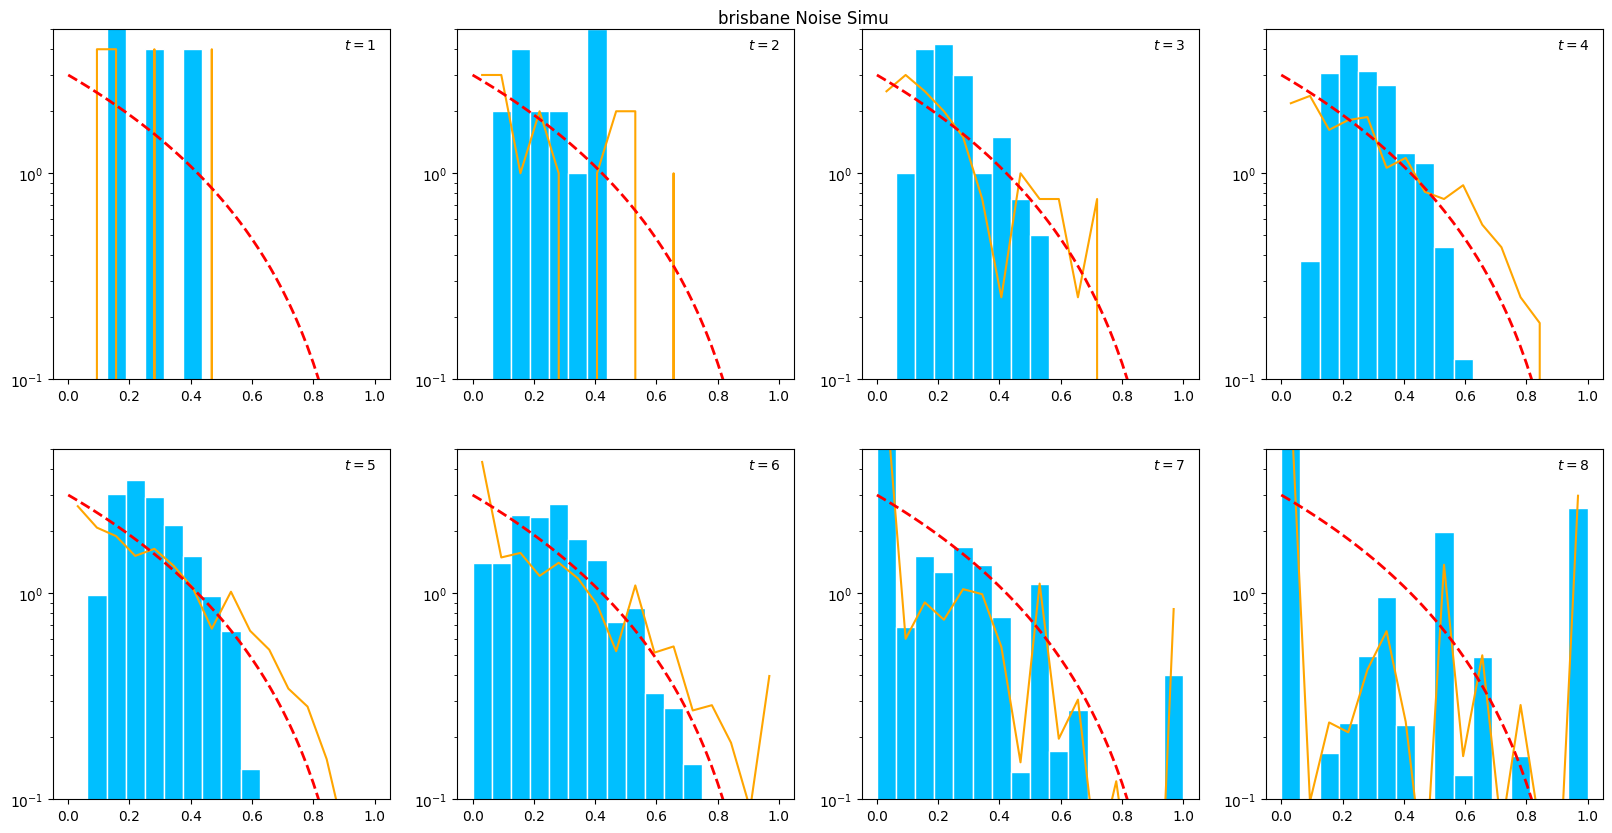

In [118]:
backend_name = 'brisbane'
n_depth = 5
n_bath = 2
n_shot = 1e5

condP = []
for t in range(1, 9):
    each = np.load(f'data/experiment/PoP/{backend_name}Simu/condP_Nb{n_bath}L{n_depth}T{t}_s1e5_{backend_name}Simu.npy')
    condP.append(each)
condP_id = []
for t in range(1, 9):
    each = np.load(f'data/experiment/PoP/ideal/condP_Nb{n_bath}L{n_depth}T{t}_s1e5.npy')
    condP_id.append(each)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
qs = np.linspace(0, 100, 51)/100
for i in range(8):
    axs[i//4, i%4].hist(condP[i], bins=np.linspace(0, 1, 17), density=True, color='deepskyblue', edgecolor='white', 
                label=fr'$t={i+1}$')
    h, b = np.histogram(condP_id[i], bins=np.linspace(0, 1, 17), density=True)
    axs[i//4, i%4].plot((b[1:]+b[:-1])/2, h, c='orange')
    axs[i//4, i%4].plot(qs, (2**2 - 1)*(1-qs)**(2**2-2), '--', lw=2, color='r')
    axs[i//4, i%4].set_yscale('log')
    axs[i//4, i%4].set_ylim(0.1, 5)
    axs[i//4, i%4].text(0.9, 4, fr'$t={i+1}$')
fig.suptitle(f'{backend_name} Noise Simu', y=0.9)